# Practica 2: Recurrent Neural Network (RNN))


En esta segunda parte de la practica 2 vamos a implementar una RNN usando Keras para la estimación de valores en una serie de tiempo.

Una red neuronal recurrente (RNN) es un tipo de red neuronal diseñada para procesar datos secuenciales, es decir, datos en los que el orden de los elementos es importante, como texto o series temporales. A diferencia de las redes neuronales estándar, que tratan cada entrada de forma independiente, las RNN tienen una "memoria" que les permite incorporar información de entradas anteriores en su procesamiento de las entradas actuales. Esto las hace idóneas para tareas como la traducción de idiomas, el reconocimiento de voz y la predicción de series temporales.

**Datos secuenciales:**

Las RNN están diseñadas específicamente para manejar datos en los que el orden de los elementos es crucial. Los ejemplos incluyen:

*   Texto: Las palabras de una frase tienen un orden específico que afecta al significado.
*   Series temporales: Puntos de datos recogidos a lo largo del tiempo, como los precios de las acciones o los datos meteorológicos, en los que los valores pasados influyen en los valores futuros.

**Memoria:**
A diferencia de las redes feedforward, las RNN tienen bucles que permiten pasar información de un paso de la secuencia al siguiente, creando una especie de «memoria».
Funcionamiento:

*   En cada paso de la secuencia, la RNN toma como entrada la información actual y el «estado oculto» (que contiene información de pasos anteriores).
*   A continuación, procesa estas entradas para producir una salida y actualiza el estado oculto para el siguiente paso.
*   Esto permite a la red «recordar» información pasada y utilizarla para influir en el procesamiento de la entrada actual.

**Aplicaciones:**

*   Procesamiento del lenguaje natural (PLN): Traducción de idiomas, análisis de sentimientos, generación de textos, reconocimiento de voz.
*   Análisis de series temporales: Predicción de cotizaciones bursátiles, patrones meteorológicos y otros datos dependientes del tiempo.
*   Otras tareas de datos secuenciales: Análisis de vídeo, generación de música.



### Importar librerias



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

##Cargar datos
Primero vamos a cargar una serie de tiempo que se encuentra en el archivo monthly-sunspots.csv.

El archivo «monthly-sunspots.csv» contiene datos mensuales de manchas solares, que es una serie temporal del número de manchas solares observadas cada mes. Las manchas solares son fenómenos temporales en la fotosfera del Sol que aparecen como manchas más oscuras que las zonas circundantes. Son regiones de temperatura superficial reducida causada por concentraciones de flujo de campo magnético que inhiben la convección.

In [2]:
#Leer datos (solo la segunda columna) en formato float32
df = pd.read_csv("monthly-sunspots.csv",usecols=[1])
data = np.array(df.values.astype('float32'))
#Scalar los datos de 0 a 1 y obtener un arreglo de 1d
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data).flatten()
n = len(data)
# Dividir los datos en entrenamiento (80%) y prueba (20%)
split=int(n*0.8)
train_data = data[range(split)]
test_data = data[split:]

(2256,)


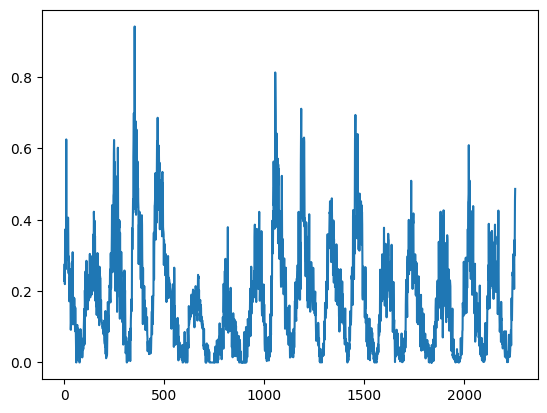

In [3]:
#Visualizar datos de entrenamiento
print(train_data.shape)
plt.plot(train_data)

(564,)


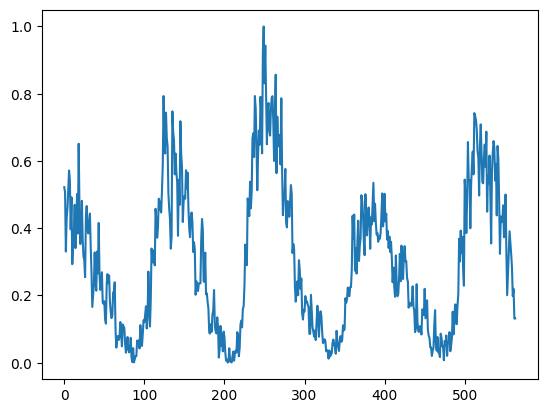

In [4]:
#Visualizar datos de prueba
print(test_data.shape)
plt.plot(test_data)

##Preparación de datos para entrenamiento
El siguiente paso es preparar los datos para el entrenamiento del modelo Keras. El array de entrada debe tener la siguiente forma: total_samples x time_steps x features.

Hay muchas formas de preparar los datos de series temporales para el entrenamiento. Crearemos filas de entrada con pasos de tiempo no solapados.

Un ejemplo para time_steps = 2 sería:

Entrada:

x = [(0,10), (20,30), (40,50)]

t = [(0, 1), ( 2, 3), ( 4, 5)]

Salida:

y = [   20,      40,       60]

t = [    2,       4,        6]

Aquí, time_steps denota el número de pasos de tiempo anteriores a utilizar para predecir el siguiente valor de los datos de series temporales.

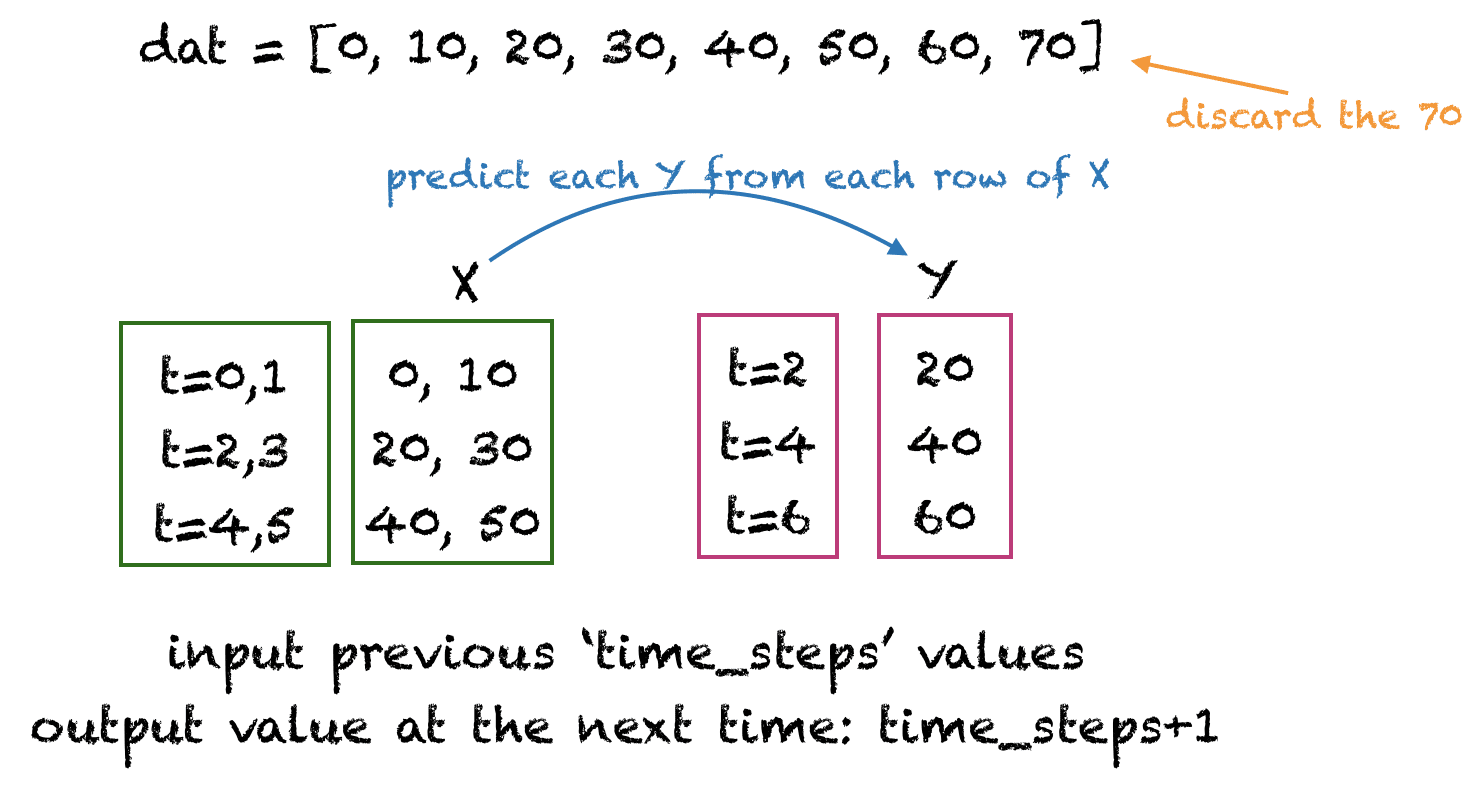

La siguiente función permitira construir estos arreglos. Recibiendo los datos y el time_steps. La salida de la función son los vectores X y Y, donde Y es el valor a estimar mediante la red.

*   Usaremos el metodo np.arange(start, stop, step) para generar los indices entre [start, stop) espaciados por time_steps
*   El total de muestras será los datos disponibles / time_steps



In [5]:
#Metodo para construir los conjuntos X y Y de entrenamiento y prueba
def get_XY(dat, time_steps):
    # Indices del arreglo Y
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    # Arreglo de los valores a estimar
    Y = dat[Y_ind]
    # Organización de X en un arreglo de
    # total_samples x time_steps x features
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X,(rows_x, time_steps, 1))
    return X, Y

#Usaremos un time_steps de 12 meses
time_steps = 12
#Organizamos los datos de entrenamiento
trainX, trainY = get_XY(train_data,time_steps)
#Organizamos los datos de prueba
testX, testY = get_XY(test_data,time_steps)

In [6]:
#Revisamos las dimensiones de los conjuntos
#Datos de entrenamiento
print("Datos de entrenamiento: ")
print("X: ", trainX.shape)
print("Y: ", trainY.shape)

Datos de entrenamiento: 
X:  (187, 12, 1)
Y:  (187,)


In [7]:
#Datos de prueba
print("Datos de prueba: ")
print("X: ", testX.shape)
print("Y: ", testY.shape)

Datos de prueba: 
X:  (46, 12, 1)
Y:  (46,)


Nota: en este ejemplo estamos usando 12 muestras en el tiempo para estimar un valor de mancha solar.

##Construcción del modelo RNN
Vamos a emplear el modelo secuencial con una RNN, utilizaremos un arquitectura sencilla:


*   Una capa RNN con 3 neuronas ocultas
*   Una capa RNN de salida con 1 neurona para predecir el valor
*   Usaremos la función de activación tanh
*   Asegúrese de establecer return_sequences=True para todas las capas recurrentes (excepto la última, si sólo le interesa la última salida). Sino, la salida será un arreglo 2D (solo con la salida del ultimo paso) en vez de un arreglo 3D (con las salidas de TODOS los pasos). Esto genera un error en las siguientes capas.

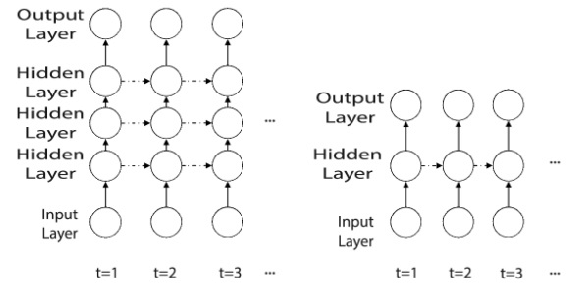


In [8]:
#Importar librerias
from keras.models import Sequential
from keras.layers import SimpleRNN

In [9]:
#Configurar el modelo
model = Sequential()
#Capa RNN con 3 neuronas
model.add(SimpleRNN(3, input_shape=(time_steps,1), activation='tanh',return_sequences=True))
#Capa RNN con 1 neurona
model.add(SimpleRNN(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
#Exploración de la arquitectura
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12, 3)          │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

##Entrenamiento del modelo

In [11]:
#Parametros para entrenamiento
model.compile(optimizer='adam',
              loss='mean_squared_error')
#Entrenamiento
history = model.fit(trainX, trainY, epochs=20, batch_size=1)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0123
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0102
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0064
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0049
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0061
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0057
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040
Epoch 10/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0048
Epoch 11/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045
Epoch 12/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046
Epoch 13/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043
Epoch 14/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058
Epoch 15/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

##Predicciones con el modelo

In [12]:
# Aplicar el modelo a datos de prueba
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


##Metricas de desempeño

In [13]:
# Vamos a usar las mismas metricas de la practica 1
from sklearn import metrics

print('MSE: ', metrics.mean_squared_error(testY,test_predict))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(testY,test_predict)))
print('MAE: ', metrics.mean_absolute_error(testY,test_predict))
print('R2_score: ', metrics.r2_score(testY,test_predict))

MSE:  0.009126982651650906
RMSE:  0.09553524298211057
MAE:  0.07189452648162842
R2_score:  0.802238404750824


##Visualización del resultado

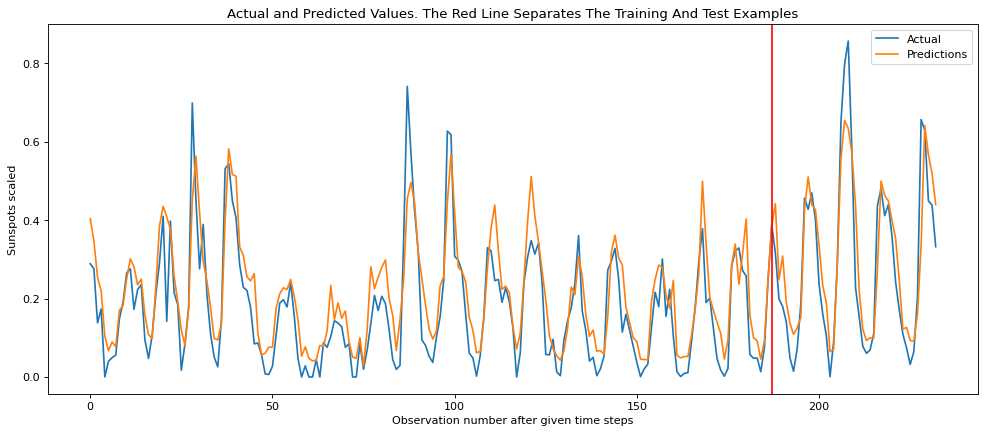

In [14]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)

# Long Short-Term Memory (LSTM)

Una red de memoria a corto plazo (LSTM) es un tipo de red neuronal recurrente (RNN) diseñada específicamente para manejar datos secuenciales y aprender dependencias a largo plazo. A diferencia de las RNN estándar, las LSTM recuerdan mejor la información durante periodos más largos, mitigando el problema del gradiente de fuga que puede dificultar el aprendizaje en las RNN tradicionales. Esto las hace adecuadas para tareas en las que el orden de los datos es importante, como el reconocimiento de voz, la traducción automática y el análisis de series temporales.

**Dependencias a largo plazo:**
Uno de los principales retos de las RNN es el aprendizaje de las dependencias a largo plazo, es decir, la capacidad de relacionar la información desde el principio de una secuencia hasta el final. Las RNN estándar se enfrentan a este reto debido al problema del gradiente evanescente, en el que los gradientes (información sobre cómo ajustar los pesos de la red) se vuelven muy pequeños durante la retropropagación, lo que dificulta el aprendizaje.

**La solución de LSTM:**
Las LSTM solucionan este problema introduciendo una célula de memoria y «gates» que regulan el flujo de información que entra y sale de la célula. Estas puertas, que incluyen puertas de entrada, olvido y salida, determinan selectivamente qué información se almacena, se descarta o se emite en cada paso temporal.

In [15]:
#Importar el modelo
from keras.layers import LSTM
#Configurar el modelo
model = Sequential()
model.add(LSTM(3, input_shape=(time_steps,1), activation='tanh',return_sequences=True))
model.add(SimpleRNN(1))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 3)          │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65 (260.00 B)

 Trainable params: 65 (260.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Parametros para entrenamiento
model.compile(optimizer='adam',
              loss='mean_squared_error')
#Entrenamiento
history = model.fit(trainX, trainY, epochs=20, batch_size=1)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0357
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0056
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0047
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0042
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0049
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048
Epoch 10/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039
Epoch 11/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0049
Epoch 12/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0050
Epoch 13/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0043
Epoch 14/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0034
Epoch 15/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo

In [17]:
#Desempeño
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
print('MSE: ', metrics.mean_squared_error(testY,test_predict))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(testY,test_predict)))
print('MAE: ', metrics.mean_absolute_error(testY,test_predict))
print('R2_score: ', metrics.r2_score(testY,test_predict))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MSE:  0.007887349463999271
RMSE:  0.08881075083569145
MAE:  0.06781063973903656
R2_score:  0.8290985226631165


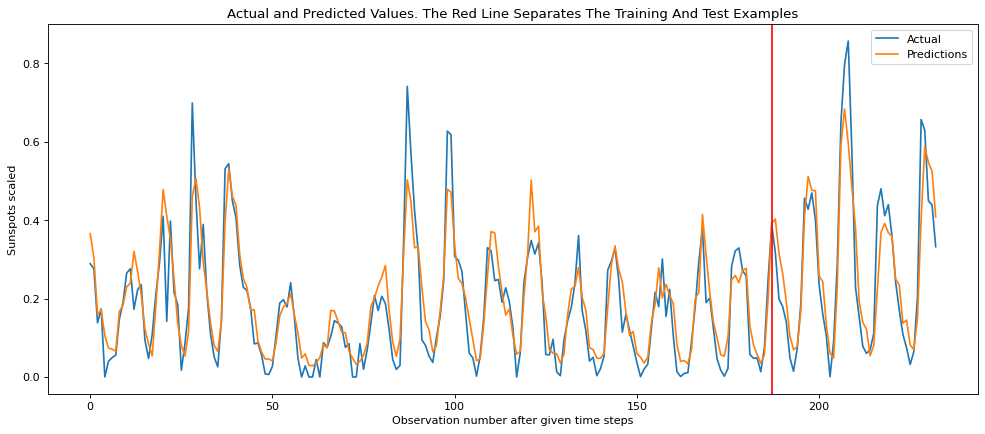

In [18]:
plot_result(trainY, testY, train_predict, test_predict)

# ¡Gran trabajo!